In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
class CNNB(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias = False, padding_mode = "reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),  
        )
    def forward(self, x):
        return self.conv(x)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], kernel_size = 4, stride = 2, padding = 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNB(in_channels, feature, stride = 1 if feature == features[-1] else 2),
            )
            in_channels = feature
        
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, y):
        x = torch.cat([x,y], dim = 1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [4]:
def test():
    x = torch.randn((1,3,256,256))
    y = torch.randn((1,3,256,256))
    model = Discriminator()
    pred = model(x,y)
    print(pred.shape) 
test()

torch.Size([1, 1, 26, 26])


In [5]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [6]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [7]:
def test_():
    x = torch.randn((1,3,256,256))
    model = Generator(in_channels=3, features=64)
    pred = model(x)
    print(pred.shape)
test_()

torch.Size([1, 3, 256, 256])


In [8]:
from PIL import Image

In [9]:
LEARNING_RATE = 2e-4
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from torchvision.transforms import Lambda
both_transform = A.Compose([A.Resize(width=256, height=256),], additional_targets={"image0": "image"},)
transform = A.Compose([A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),ToTensorV2(),])
class GroundTruthNoisyDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.folders = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_name = self.folders[idx]
        ground_truth_path = os.path.join(self.root_dir, folder_name, "gt.jpg")
        noisy_path = os.path.join(self.root_dir, folder_name, "noise.jpg")
        ground_truth = np.array(Image.open(ground_truth_path))
        noisy = np.array(Image.open(noisy_path))
        augmentations = both_transform(image=noisy, image0=ground_truth)
        noisy = augmentations["image"]
        ground_truth = augmentations["image0"]
        ground_truth = transform(image = ground_truth)["image"]
        noisy = transform(image = noisy)["image"]
        return noisy, ground_truth

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
root_tr = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Train"
root_te = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Test"

In [12]:
train_dataset = GroundTruthNoisyDataset(root_tr)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)

valid_dataset = GroundTruthNoisyDataset(root_te)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
from torchvision.utils import save_image

def psnr(mse, max_pixel_val=255.0):
    return 10 * math.log10(max_pixel_val**2 / mse)

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    if not os.path.exists(folder):
        os.makedirs(folder)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

def val_psnr(gen, val_loader, epoch):
    mse = nn.MSELoss()
    gen.eval()
    tot_psnr = 0
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    for x,y in val_loader:
        with torch.no_grad():
            x,y = x.to(DEVICE), y.to(DEVICE)
            y_fake = gen(x)
            y_fake = y_fake*0.5 + 0.5  # remove normalization#
            y_real = y*0.5 + 0.5
            mse_ = mse(y_fake*255.0, y_real*255.0)
            met = psnr(mse_)
            tot_psnr += met
    gen.train()
    return tot_psnr/len(val_loader)

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [15]:
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"
from tqdm import tqdm
disc = Discriminator(in_channels=3).to(DEVICE)
gen = Generator(in_channels=3).to(DEVICE)
opt_disc = torch.optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()
if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [16]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    disc = nn.DataParallel(disc)
    gen = nn.DataParallel(gen)

Using 2 GPUs!


In [17]:
from torchvision.io import read_image
train_psnr = []
test_psnr = []
import math
mse = nn.MSELoss()
for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader, leave=True)
    tot_psnr = 0
    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            y_famke = y_fake * 0.5 + 0.5  # remove normalization#
            y_real = y*0.5 + 0.5
            mse_ = mse(y_famke*255.0, y_real*255.0)
            met = psnr(mse_)
            tot_psnr += met
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1
        
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )
    if SAVE_MODEL and epoch % 10 == 0:
        save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
    psnr_train = tot_psnr/len(train_loader)
    psnr_test = val_psnr(gen, valid_loader, epoch)
    train_psnr.append(psnr_train)
    save_some_examples(gen, valid_loader, epoch, folder="/kaggle/working/evaluation")
    test_psnr.append(psnr_test)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train PSNR: {psnr_train:.4f}, Valid PSNR: {psnr_test:.4f}")

100%|██████████| 83/83 [00:38<00:00,  2.15it/s, D_fake=0.331, D_real=0.777]


=> Saving checkpoint
=> Saving checkpoint
Epoch [1/500], Train PSNR: 16.1622, Valid PSNR: 21.1556


100%|██████████| 83/83 [00:19<00:00,  4.26it/s, D_fake=0.424, D_real=0.637]


Epoch [2/500], Train PSNR: 24.6315, Valid PSNR: 27.2161


100%|██████████| 83/83 [00:19<00:00,  4.25it/s, D_fake=0.48, D_real=0.467] 


Epoch [3/500], Train PSNR: 26.6776, Valid PSNR: 25.0946


100%|██████████| 83/83 [00:19<00:00,  4.23it/s, D_fake=0.366, D_real=0.612]


Epoch [4/500], Train PSNR: 27.6303, Valid PSNR: 25.2722


100%|██████████| 83/83 [00:19<00:00,  4.21it/s, D_fake=0.484, D_real=0.477]


Epoch [5/500], Train PSNR: 29.0938, Valid PSNR: 28.4997


100%|██████████| 83/83 [00:19<00:00,  4.20it/s, D_fake=0.467, D_real=0.531]


Epoch [6/500], Train PSNR: 29.5248, Valid PSNR: 29.1852


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.518, D_real=0.529]


Epoch [7/500], Train PSNR: 29.4777, Valid PSNR: 28.4253


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.373, D_real=0.621]


Epoch [8/500], Train PSNR: 29.7402, Valid PSNR: 29.9030


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.359, D_real=0.645]


Epoch [9/500], Train PSNR: 30.4087, Valid PSNR: 30.9691


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.31, D_real=0.735] 


Epoch [10/500], Train PSNR: 30.7361, Valid PSNR: 31.7565


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.101, D_real=0.968] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/500], Train PSNR: 30.2986, Valid PSNR: 29.8254


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0193, D_real=0.962]


Epoch [12/500], Train PSNR: 30.6432, Valid PSNR: 27.8941


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.435, D_real=0.495]  


Epoch [13/500], Train PSNR: 30.6766, Valid PSNR: 29.5966


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.108, D_real=0.913]


Epoch [14/500], Train PSNR: 31.0878, Valid PSNR: 31.4150


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0312, D_real=0.961]


Epoch [15/500], Train PSNR: 30.0458, Valid PSNR: 31.1123


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.445, D_real=0.559] 


Epoch [16/500], Train PSNR: 30.7443, Valid PSNR: 31.9388


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.091, D_real=0.793] 


Epoch [17/500], Train PSNR: 31.2269, Valid PSNR: 31.5720


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.167, D_real=0.876] 


Epoch [18/500], Train PSNR: 31.1021, Valid PSNR: 31.0269


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0453, D_real=0.663]


Epoch [19/500], Train PSNR: 30.9394, Valid PSNR: 30.7876


100%|██████████| 83/83 [00:20<00:00,  4.08it/s, D_fake=0.152, D_real=0.91]  


Epoch [20/500], Train PSNR: 31.1546, Valid PSNR: 28.2806


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0642, D_real=0.96] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/500], Train PSNR: 31.0502, Valid PSNR: 29.7610


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.674, D_real=0.313] 


Epoch [22/500], Train PSNR: 30.0683, Valid PSNR: 28.9409


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0688, D_real=0.928]


Epoch [23/500], Train PSNR: 30.7703, Valid PSNR: 31.2063


100%|██████████| 83/83 [00:20<00:00,  4.07it/s, D_fake=0.281, D_real=0.76]  


Epoch [24/500], Train PSNR: 30.8376, Valid PSNR: 30.2876


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.333, D_real=0.484] 


Epoch [25/500], Train PSNR: 31.1715, Valid PSNR: 31.2054


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.116, D_real=0.738] 


Epoch [26/500], Train PSNR: 31.1336, Valid PSNR: 30.3256


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.206, D_real=0.749] 


Epoch [27/500], Train PSNR: 29.9644, Valid PSNR: 31.3255


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.244, D_real=0.71]  


Epoch [28/500], Train PSNR: 31.1596, Valid PSNR: 31.2503


100%|██████████| 83/83 [00:20<00:00,  4.08it/s, D_fake=0.054, D_real=0.984] 


Epoch [29/500], Train PSNR: 30.4235, Valid PSNR: 31.5197


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0315, D_real=0.984]


Epoch [30/500], Train PSNR: 31.0660, Valid PSNR: 31.0185


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.224, D_real=0.731] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [31/500], Train PSNR: 31.2955, Valid PSNR: 27.5447


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0295, D_real=0.957]


Epoch [32/500], Train PSNR: 30.6090, Valid PSNR: 29.3231


100%|██████████| 83/83 [00:20<00:00,  4.07it/s, D_fake=0.276, D_real=0.607] 


Epoch [33/500], Train PSNR: 31.2302, Valid PSNR: 31.8649


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.162, D_real=0.826] 


Epoch [34/500], Train PSNR: 31.2633, Valid PSNR: 31.5836


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0798, D_real=0.762]


Epoch [35/500], Train PSNR: 31.0417, Valid PSNR: 31.2272


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.125, D_real=0.602] 


Epoch [36/500], Train PSNR: 31.1687, Valid PSNR: 30.8847


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0411, D_real=0.702]


Epoch [37/500], Train PSNR: 31.0173, Valid PSNR: 30.9271


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0999, D_real=0.875]


Epoch [38/500], Train PSNR: 31.3948, Valid PSNR: 30.4233


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.222, D_real=0.357] 


Epoch [39/500], Train PSNR: 31.1316, Valid PSNR: 31.3012


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.112, D_real=0.877] 


Epoch [40/500], Train PSNR: 31.3410, Valid PSNR: 28.9687


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0872, D_real=0.886]


=> Saving checkpoint
=> Saving checkpoint
Epoch [41/500], Train PSNR: 31.3751, Valid PSNR: 31.3559


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.0378, D_real=0.968]


Epoch [42/500], Train PSNR: 31.0821, Valid PSNR: 30.8776


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.439, D_real=0.239] 


Epoch [43/500], Train PSNR: 31.7236, Valid PSNR: 31.7158


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.266, D_real=0.653] 


Epoch [44/500], Train PSNR: 31.8157, Valid PSNR: 32.6244


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.116, D_real=0.862] 


Epoch [45/500], Train PSNR: 31.8256, Valid PSNR: 31.8105


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.0863, D_real=0.927]


Epoch [46/500], Train PSNR: 31.5930, Valid PSNR: 31.2982


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0309, D_real=0.896]


Epoch [47/500], Train PSNR: 31.4653, Valid PSNR: 31.1746


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0633, D_real=0.966]


Epoch [48/500], Train PSNR: 31.3780, Valid PSNR: 31.1654


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0348, D_real=0.986]


Epoch [49/500], Train PSNR: 31.4828, Valid PSNR: 32.4748


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.00888, D_real=0.965]


Epoch [50/500], Train PSNR: 31.7601, Valid PSNR: 31.6773


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0454, D_real=0.759]


=> Saving checkpoint
=> Saving checkpoint
Epoch [51/500], Train PSNR: 31.7736, Valid PSNR: 28.7943


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0282, D_real=0.955]


Epoch [52/500], Train PSNR: 31.5347, Valid PSNR: 30.6817


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.187, D_real=0.552] 


Epoch [53/500], Train PSNR: 31.8956, Valid PSNR: 32.1444


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0419, D_real=0.93] 


Epoch [54/500], Train PSNR: 31.7614, Valid PSNR: 31.7081


100%|██████████| 83/83 [00:20<00:00,  4.08it/s, D_fake=0.00677, D_real=0.975]


Epoch [55/500], Train PSNR: 31.7748, Valid PSNR: 26.6584


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.107, D_real=0.914] 


Epoch [56/500], Train PSNR: 31.9250, Valid PSNR: 32.5671


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0597, D_real=0.899]


Epoch [57/500], Train PSNR: 31.9824, Valid PSNR: 30.4088


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0224, D_real=0.693] 


Epoch [58/500], Train PSNR: 31.8176, Valid PSNR: 30.9633


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.143, D_real=0.556] 


Epoch [59/500], Train PSNR: 31.7581, Valid PSNR: 32.4949


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.018, D_real=0.969] 


Epoch [60/500], Train PSNR: 31.8619, Valid PSNR: 32.4537


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0394, D_real=0.925]


=> Saving checkpoint
=> Saving checkpoint
Epoch [61/500], Train PSNR: 31.8131, Valid PSNR: 32.3004


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.00726, D_real=0.958]


Epoch [62/500], Train PSNR: 32.0631, Valid PSNR: 32.3356


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0498, D_real=0.974]


Epoch [63/500], Train PSNR: 32.3198, Valid PSNR: 32.5573


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0387, D_real=0.924] 


Epoch [64/500], Train PSNR: 32.4020, Valid PSNR: 31.9782


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0217, D_real=0.952]


Epoch [65/500], Train PSNR: 32.4683, Valid PSNR: 32.3869


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.032, D_real=0.992] 


Epoch [66/500], Train PSNR: 32.5658, Valid PSNR: 32.4761


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.138, D_real=0.73]  


Epoch [67/500], Train PSNR: 33.0024, Valid PSNR: 33.2579


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0773, D_real=0.861]


Epoch [68/500], Train PSNR: 32.7204, Valid PSNR: 20.1858


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0809, D_real=0.978]


Epoch [69/500], Train PSNR: 30.8421, Valid PSNR: 32.6123


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.238, D_real=0.474] 


Epoch [70/500], Train PSNR: 31.9187, Valid PSNR: 31.3190


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0764, D_real=0.683] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [71/500], Train PSNR: 32.3110, Valid PSNR: 32.9023


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0628, D_real=0.424]


Epoch [72/500], Train PSNR: 32.4604, Valid PSNR: 32.7557


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0645, D_real=0.981]


Epoch [73/500], Train PSNR: 32.6427, Valid PSNR: 31.7757


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.122, D_real=0.64]  


Epoch [74/500], Train PSNR: 32.6949, Valid PSNR: 30.7809


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.00308, D_real=0.934]


Epoch [75/500], Train PSNR: 32.5540, Valid PSNR: 32.4668


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.00623, D_real=0.968]


Epoch [76/500], Train PSNR: 32.4251, Valid PSNR: 33.2116


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0527, D_real=0.847]


Epoch [77/500], Train PSNR: 32.7774, Valid PSNR: 31.3598


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0632, D_real=0.931] 


Epoch [78/500], Train PSNR: 32.7504, Valid PSNR: 32.9778


100%|██████████| 83/83 [00:19<00:00,  4.18it/s, D_fake=0.0479, D_real=0.92] 


Epoch [79/500], Train PSNR: 32.4599, Valid PSNR: 32.4863


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.17, D_real=0.858]   


Epoch [80/500], Train PSNR: 32.8165, Valid PSNR: 32.7141


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.119, D_real=0.701] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [81/500], Train PSNR: 32.7568, Valid PSNR: 32.8690


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0527, D_real=0.925]


Epoch [82/500], Train PSNR: 32.9578, Valid PSNR: 33.0329


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.089, D_real=0.9]   


Epoch [83/500], Train PSNR: 32.7564, Valid PSNR: 32.0362


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0577, D_real=0.449]


Epoch [84/500], Train PSNR: 32.5051, Valid PSNR: 32.8829


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.361, D_real=0.438]  


Epoch [85/500], Train PSNR: 33.0050, Valid PSNR: 33.0329


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.273, D_real=0.879]


Epoch [86/500], Train PSNR: 33.2041, Valid PSNR: 30.8242


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.115, D_real=0.879] 


Epoch [87/500], Train PSNR: 32.8481, Valid PSNR: 33.6597


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.16, D_real=0.6]   


Epoch [88/500], Train PSNR: 32.9411, Valid PSNR: 32.8104


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.201, D_real=0.83]  


Epoch [89/500], Train PSNR: 32.7649, Valid PSNR: 33.4128


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.355, D_real=0.496] 


Epoch [90/500], Train PSNR: 32.9143, Valid PSNR: 32.7594


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0864, D_real=0.807]


=> Saving checkpoint
=> Saving checkpoint
Epoch [91/500], Train PSNR: 33.3070, Valid PSNR: 32.9644


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0491, D_real=0.752]


Epoch [92/500], Train PSNR: 32.9143, Valid PSNR: 32.9506


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.048, D_real=0.959] 


Epoch [93/500], Train PSNR: 32.7471, Valid PSNR: 33.3162


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0467, D_real=0.856]


Epoch [94/500], Train PSNR: 32.7185, Valid PSNR: 31.2488


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.00595, D_real=0.959]


Epoch [95/500], Train PSNR: 32.8731, Valid PSNR: 33.2100


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.116, D_real=0.922]  


Epoch [96/500], Train PSNR: 32.8182, Valid PSNR: 33.2749


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0567, D_real=0.811]


Epoch [97/500], Train PSNR: 32.8522, Valid PSNR: 33.3344


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0238, D_real=0.961] 


Epoch [98/500], Train PSNR: 33.2029, Valid PSNR: 33.4868


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0571, D_real=0.877]


Epoch [99/500], Train PSNR: 33.0279, Valid PSNR: 31.5170


100%|██████████| 83/83 [00:20<00:00,  4.05it/s, D_fake=0.0767, D_real=0.959]


Epoch [100/500], Train PSNR: 33.0429, Valid PSNR: 32.8241


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.0412, D_real=0.877]


=> Saving checkpoint
=> Saving checkpoint
Epoch [101/500], Train PSNR: 32.9661, Valid PSNR: 32.6514


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0439, D_real=0.844]


Epoch [102/500], Train PSNR: 33.1602, Valid PSNR: 31.8880


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0385, D_real=0.791]


Epoch [103/500], Train PSNR: 32.1549, Valid PSNR: 32.4543


100%|██████████| 83/83 [00:20<00:00,  4.07it/s, D_fake=0.026, D_real=0.77]   


Epoch [104/500], Train PSNR: 32.5831, Valid PSNR: 31.6015


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.422, D_real=0.43]   


Epoch [105/500], Train PSNR: 33.0506, Valid PSNR: 34.2215


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.304, D_real=0.744]


Epoch [106/500], Train PSNR: 33.7423, Valid PSNR: 32.9199


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0538, D_real=0.913]


Epoch [107/500], Train PSNR: 33.2718, Valid PSNR: 29.4856


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.159, D_real=0.564] 


Epoch [108/500], Train PSNR: 32.8791, Valid PSNR: 33.6488


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0392, D_real=0.955]


Epoch [109/500], Train PSNR: 32.8400, Valid PSNR: 32.0200


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.00958, D_real=0.988]


Epoch [110/500], Train PSNR: 32.9074, Valid PSNR: 32.8617


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.243, D_real=0.833]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [111/500], Train PSNR: 33.0056, Valid PSNR: 33.1670


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.365, D_real=0.681] 


Epoch [112/500], Train PSNR: 33.3368, Valid PSNR: 34.1018


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0385, D_real=0.956]


Epoch [113/500], Train PSNR: 33.3244, Valid PSNR: 33.3352


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.126, D_real=0.753] 


Epoch [114/500], Train PSNR: 32.9861, Valid PSNR: 32.6432


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0334, D_real=0.52] 


Epoch [115/500], Train PSNR: 33.3110, Valid PSNR: 23.2410


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.063, D_real=0.908]  


Epoch [116/500], Train PSNR: 32.3989, Valid PSNR: 32.7335


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0781, D_real=0.897]


Epoch [117/500], Train PSNR: 32.9929, Valid PSNR: 34.0691


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.069, D_real=0.828] 


Epoch [118/500], Train PSNR: 33.0295, Valid PSNR: 32.9056


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.109, D_real=0.689] 


Epoch [119/500], Train PSNR: 33.2237, Valid PSNR: 33.3937


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0548, D_real=0.843]


Epoch [120/500], Train PSNR: 33.3528, Valid PSNR: 33.7081


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.396, D_real=0.449] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [121/500], Train PSNR: 33.1725, Valid PSNR: 34.0192


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0473, D_real=0.835]


Epoch [122/500], Train PSNR: 33.3321, Valid PSNR: 33.2643


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0763, D_real=0.864]


Epoch [123/500], Train PSNR: 33.2066, Valid PSNR: 34.1282


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0789, D_real=0.871]


Epoch [124/500], Train PSNR: 33.1881, Valid PSNR: 33.6462


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.108, D_real=0.592]  


Epoch [125/500], Train PSNR: 33.2529, Valid PSNR: 33.5677


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.00528, D_real=0.909]


Epoch [126/500], Train PSNR: 33.2361, Valid PSNR: 33.0601


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.135, D_real=0.936]  


Epoch [127/500], Train PSNR: 33.0816, Valid PSNR: 32.3164


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.122, D_real=0.838] 


Epoch [128/500], Train PSNR: 33.4623, Valid PSNR: 34.0670


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0188, D_real=0.989]


Epoch [129/500], Train PSNR: 32.9803, Valid PSNR: 33.3960


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.0221, D_real=0.944]


Epoch [130/500], Train PSNR: 33.1247, Valid PSNR: 33.0766


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.385, D_real=0.342]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [131/500], Train PSNR: 33.2291, Valid PSNR: 31.6367


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0635, D_real=0.798]


Epoch [132/500], Train PSNR: 33.3138, Valid PSNR: 33.2770


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0428, D_real=0.512] 


Epoch [133/500], Train PSNR: 33.0564, Valid PSNR: 32.8069


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.181, D_real=0.217] 


Epoch [134/500], Train PSNR: 32.6176, Valid PSNR: 32.7259


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0287, D_real=0.896] 


Epoch [135/500], Train PSNR: 33.1588, Valid PSNR: 33.2083


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0956, D_real=0.737] 


Epoch [136/500], Train PSNR: 33.1182, Valid PSNR: 33.2063


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.105, D_real=0.886] 


Epoch [137/500], Train PSNR: 32.9735, Valid PSNR: 33.2730


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.473, D_real=0.367] 


Epoch [138/500], Train PSNR: 33.4021, Valid PSNR: 34.3150


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.106, D_real=0.839] 


Epoch [139/500], Train PSNR: 33.5073, Valid PSNR: 32.2628


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.303, D_real=0.421] 


Epoch [140/500], Train PSNR: 33.1847, Valid PSNR: 32.9643


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.333, D_real=0.643]


=> Saving checkpoint
=> Saving checkpoint
Epoch [141/500], Train PSNR: 33.8086, Valid PSNR: 33.9442


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.114, D_real=0.821]


Epoch [142/500], Train PSNR: 33.4567, Valid PSNR: 33.9115


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0113, D_real=0.895]


Epoch [143/500], Train PSNR: 32.9676, Valid PSNR: 29.7457


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0608, D_real=0.942]


Epoch [144/500], Train PSNR: 33.1366, Valid PSNR: 33.9912


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0613, D_real=0.775]


Epoch [145/500], Train PSNR: 33.4773, Valid PSNR: 33.6336


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0387, D_real=0.985]


Epoch [146/500], Train PSNR: 33.2260, Valid PSNR: 33.7151


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.103, D_real=0.495]  


Epoch [147/500], Train PSNR: 33.0628, Valid PSNR: 33.2711


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.149, D_real=0.803] 


Epoch [148/500], Train PSNR: 33.2599, Valid PSNR: 30.0549


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.204, D_real=0.5]   


Epoch [149/500], Train PSNR: 33.2282, Valid PSNR: 33.4445


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0421, D_real=0.764]


Epoch [150/500], Train PSNR: 33.1957, Valid PSNR: 32.4243


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0735, D_real=0.924] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [151/500], Train PSNR: 32.6658, Valid PSNR: 33.3400


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0295, D_real=0.875] 


Epoch [152/500], Train PSNR: 32.7985, Valid PSNR: 33.3768


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.046, D_real=0.988]  


Epoch [153/500], Train PSNR: 31.5455, Valid PSNR: 32.1148


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0224, D_real=0.988]


Epoch [154/500], Train PSNR: 31.6349, Valid PSNR: 20.9806


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0124, D_real=0.95]  


Epoch [155/500], Train PSNR: 31.2490, Valid PSNR: 28.7661


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0319, D_real=0.914] 


Epoch [156/500], Train PSNR: 32.1411, Valid PSNR: 32.1774


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.257, D_real=0.693]


Epoch [157/500], Train PSNR: 33.5586, Valid PSNR: 29.6916


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0698, D_real=0.888]


Epoch [158/500], Train PSNR: 33.3922, Valid PSNR: 33.5939


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0535, D_real=0.881]


Epoch [159/500], Train PSNR: 33.4091, Valid PSNR: 33.8476


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.206, D_real=0.342] 


Epoch [160/500], Train PSNR: 33.5277, Valid PSNR: 33.9963


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0488, D_real=0.95] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [161/500], Train PSNR: 33.4178, Valid PSNR: 32.0615


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0652, D_real=0.922]


Epoch [162/500], Train PSNR: 33.2446, Valid PSNR: 33.7724


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0428, D_real=0.743]


Epoch [163/500], Train PSNR: 33.2569, Valid PSNR: 33.8264


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0318, D_real=0.949]


Epoch [164/500], Train PSNR: 33.4088, Valid PSNR: 33.1595


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0382, D_real=0.876]


Epoch [165/500], Train PSNR: 33.3814, Valid PSNR: 32.7147


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0886, D_real=0.582]


Epoch [166/500], Train PSNR: 33.4389, Valid PSNR: 33.2918


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0354, D_real=0.933]


Epoch [167/500], Train PSNR: 33.5991, Valid PSNR: 33.8385


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.119, D_real=0.719]  


Epoch [168/500], Train PSNR: 33.2692, Valid PSNR: 33.9726


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.037, D_real=0.95]  


Epoch [169/500], Train PSNR: 33.3250, Valid PSNR: 32.4328


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.222, D_real=0.746] 


Epoch [170/500], Train PSNR: 33.9180, Valid PSNR: 33.1375


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.048, D_real=0.893] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [171/500], Train PSNR: 33.7183, Valid PSNR: 33.0991


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.00949, D_real=0.84]


Epoch [172/500], Train PSNR: 33.2893, Valid PSNR: 31.1330


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.275, D_real=0.632] 


Epoch [173/500], Train PSNR: 33.1835, Valid PSNR: 34.2704


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0694, D_real=0.661]


Epoch [174/500], Train PSNR: 33.4339, Valid PSNR: 33.0959


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0797, D_real=0.84] 


Epoch [175/500], Train PSNR: 33.8337, Valid PSNR: 34.1256


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0475, D_real=0.876]


Epoch [176/500], Train PSNR: 33.4999, Valid PSNR: 34.2618


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0316, D_real=0.996]


Epoch [177/500], Train PSNR: 32.3005, Valid PSNR: 28.3979


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0202, D_real=0.999]


Epoch [178/500], Train PSNR: 29.5532, Valid PSNR: 26.5929


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0121, D_real=0.998] 


Epoch [179/500], Train PSNR: 29.6660, Valid PSNR: 27.8780


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.00233, D_real=0.949]


Epoch [180/500], Train PSNR: 31.2533, Valid PSNR: 32.4241


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0372, D_real=0.992] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [181/500], Train PSNR: 30.8591, Valid PSNR: 30.2414


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0054, D_real=0.982] 


Epoch [182/500], Train PSNR: 32.1392, Valid PSNR: 31.7912


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0418, D_real=0.932] 


Epoch [183/500], Train PSNR: 32.5290, Valid PSNR: 33.5831


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0211, D_real=0.988] 


Epoch [184/500], Train PSNR: 32.2790, Valid PSNR: 32.1265


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.00558, D_real=0.989]


Epoch [185/500], Train PSNR: 30.7870, Valid PSNR: 30.3127


100%|██████████| 83/83 [00:19<00:00,  4.20it/s, D_fake=0.019, D_real=0.996]  


Epoch [186/500], Train PSNR: 30.6017, Valid PSNR: 32.1492


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.349, D_real=0.66]   


Epoch [187/500], Train PSNR: 32.7543, Valid PSNR: 33.8993


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0956, D_real=0.744]


Epoch [188/500], Train PSNR: 33.4732, Valid PSNR: 33.2734


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.377, D_real=0.455] 


Epoch [189/500], Train PSNR: 33.2611, Valid PSNR: 30.2669


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0559, D_real=0.979]


Epoch [190/500], Train PSNR: 33.2562, Valid PSNR: 31.8912


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0374, D_real=0.822]


=> Saving checkpoint
=> Saving checkpoint
Epoch [191/500], Train PSNR: 33.3436, Valid PSNR: 33.7881


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0746, D_real=0.839]


Epoch [192/500], Train PSNR: 32.5858, Valid PSNR: 33.0990


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0304, D_real=0.972]


Epoch [193/500], Train PSNR: 33.1624, Valid PSNR: 33.3695


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.249, D_real=0.63]   


Epoch [194/500], Train PSNR: 33.3199, Valid PSNR: 34.2124


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0348, D_real=0.94] 


Epoch [195/500], Train PSNR: 33.2370, Valid PSNR: 33.9325


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0726, D_real=0.799]


Epoch [196/500], Train PSNR: 33.1091, Valid PSNR: 33.4834


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.27, D_real=0.521]  


Epoch [197/500], Train PSNR: 33.3891, Valid PSNR: 34.0902


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.312, D_real=0.254] 


Epoch [198/500], Train PSNR: 33.5834, Valid PSNR: 33.9657


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0371, D_real=0.905]


Epoch [199/500], Train PSNR: 33.5224, Valid PSNR: 32.1776


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.384, D_real=0.575] 


Epoch [200/500], Train PSNR: 32.8731, Valid PSNR: 31.3807


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.113, D_real=0.821] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [201/500], Train PSNR: 32.6509, Valid PSNR: 29.0035


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.205, D_real=0.421] 


Epoch [202/500], Train PSNR: 33.2602, Valid PSNR: 33.8417


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0282, D_real=0.888]


Epoch [203/500], Train PSNR: 33.5017, Valid PSNR: 33.3184


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.552, D_real=0.309] 


Epoch [204/500], Train PSNR: 33.2534, Valid PSNR: 33.3304


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.12, D_real=0.83]    


Epoch [205/500], Train PSNR: 33.5144, Valid PSNR: 34.1607


100%|██████████| 83/83 [00:19<00:00,  4.18it/s, D_fake=0.0462, D_real=0.927]


Epoch [206/500], Train PSNR: 33.3762, Valid PSNR: 34.1509


100%|██████████| 83/83 [00:19<00:00,  4.18it/s, D_fake=0.0685, D_real=0.832] 


Epoch [207/500], Train PSNR: 33.0131, Valid PSNR: 31.9166


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.354, D_real=0.362] 


Epoch [208/500], Train PSNR: 33.1069, Valid PSNR: 34.1193


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.172, D_real=0.427] 


Epoch [209/500], Train PSNR: 33.5566, Valid PSNR: 33.8346


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0446, D_real=0.83]  


Epoch [210/500], Train PSNR: 33.3942, Valid PSNR: 34.0557


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.13, D_real=0.667]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [211/500], Train PSNR: 33.4839, Valid PSNR: 33.4159


100%|██████████| 83/83 [00:20<00:00,  4.05it/s, D_fake=0.0363, D_real=0.975]


Epoch [212/500], Train PSNR: 33.0964, Valid PSNR: 32.1728


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0553, D_real=0.919]


Epoch [213/500], Train PSNR: 33.1603, Valid PSNR: 33.4203


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.225, D_real=0.547] 


Epoch [214/500], Train PSNR: 33.1066, Valid PSNR: 32.9149


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0828, D_real=0.93] 


Epoch [215/500], Train PSNR: 33.4994, Valid PSNR: 31.9980


100%|██████████| 83/83 [00:20<00:00,  4.08it/s, D_fake=0.0244, D_real=0.734]


Epoch [216/500], Train PSNR: 33.4095, Valid PSNR: 34.1489


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0809, D_real=0.806]


Epoch [217/500], Train PSNR: 33.3921, Valid PSNR: 33.8286


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.126, D_real=0.726] 


Epoch [218/500], Train PSNR: 33.2001, Valid PSNR: 34.3043


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.589, D_real=0.481]  


Epoch [219/500], Train PSNR: 33.4577, Valid PSNR: 34.1647


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.13, D_real=0.621]  


Epoch [220/500], Train PSNR: 33.4535, Valid PSNR: 33.9489


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0141, D_real=0.899] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [221/500], Train PSNR: 33.1345, Valid PSNR: 33.4056


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0518, D_real=0.985]


Epoch [222/500], Train PSNR: 33.4556, Valid PSNR: 33.5266


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0755, D_real=0.938]


Epoch [223/500], Train PSNR: 33.2487, Valid PSNR: 32.7222


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.228, D_real=0.64]    


Epoch [224/500], Train PSNR: 32.7931, Valid PSNR: 32.0430


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0377, D_real=0.918]


Epoch [225/500], Train PSNR: 33.2081, Valid PSNR: 34.1420


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0896, D_real=0.929]


Epoch [226/500], Train PSNR: 33.2502, Valid PSNR: 32.4851


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0265, D_real=0.932]


Epoch [227/500], Train PSNR: 33.3950, Valid PSNR: 33.4576


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.206, D_real=0.806] 


Epoch [228/500], Train PSNR: 33.6580, Valid PSNR: 33.8881


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0566, D_real=0.5] 


Epoch [229/500], Train PSNR: 33.8544, Valid PSNR: 34.1074


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0188, D_real=0.842]


Epoch [230/500], Train PSNR: 33.3262, Valid PSNR: 33.6043


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0635, D_real=0.76]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [231/500], Train PSNR: 32.8231, Valid PSNR: 33.7911


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.00226, D_real=0.985]


Epoch [232/500], Train PSNR: 33.0790, Valid PSNR: 30.6415


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0222, D_real=0.856] 


Epoch [233/500], Train PSNR: 33.1649, Valid PSNR: 33.7694


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0315, D_real=0.886]


Epoch [234/500], Train PSNR: 33.2913, Valid PSNR: 33.7437


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.17, D_real=0.642]   


Epoch [235/500], Train PSNR: 33.4563, Valid PSNR: 33.8452


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0795, D_real=0.958]


Epoch [236/500], Train PSNR: 33.2962, Valid PSNR: 32.4924


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0357, D_real=0.955]


Epoch [237/500], Train PSNR: 33.2724, Valid PSNR: 31.5403


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.123, D_real=0.913] 


Epoch [238/500], Train PSNR: 33.2366, Valid PSNR: 31.8835


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0213, D_real=0.914] 


Epoch [239/500], Train PSNR: 33.2313, Valid PSNR: 33.7635


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.374, D_real=0.501] 


Epoch [240/500], Train PSNR: 33.4571, Valid PSNR: 34.1184


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.109, D_real=0.876] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [241/500], Train PSNR: 33.4311, Valid PSNR: 33.3307


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.036, D_real=0.956]   


Epoch [242/500], Train PSNR: 32.3754, Valid PSNR: 31.9653


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0383, D_real=0.695] 


Epoch [243/500], Train PSNR: 32.9262, Valid PSNR: 33.6715


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.129, D_real=0.946] 


Epoch [244/500], Train PSNR: 33.4637, Valid PSNR: 34.0347


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.212, D_real=0.615] 


Epoch [245/500], Train PSNR: 33.3895, Valid PSNR: 33.3639


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.102, D_real=0.811] 


Epoch [246/500], Train PSNR: 33.3779, Valid PSNR: 33.7615


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.195, D_real=0.765]  


Epoch [247/500], Train PSNR: 33.5757, Valid PSNR: 34.0229


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0524, D_real=0.89] 


Epoch [248/500], Train PSNR: 33.4603, Valid PSNR: 33.1136


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0148, D_real=0.974]


Epoch [249/500], Train PSNR: 33.2608, Valid PSNR: 33.9391


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.141, D_real=0.613] 


Epoch [250/500], Train PSNR: 33.5754, Valid PSNR: 33.8174


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0521, D_real=0.966]


=> Saving checkpoint
=> Saving checkpoint
Epoch [251/500], Train PSNR: 33.5032, Valid PSNR: 32.3925


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0551, D_real=0.927] 


Epoch [252/500], Train PSNR: 33.5268, Valid PSNR: 31.9157


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.312, D_real=0.467]  


Epoch [253/500], Train PSNR: 33.3641, Valid PSNR: 34.2910


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.214, D_real=0.702]


Epoch [254/500], Train PSNR: 33.6094, Valid PSNR: 33.3921


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0381, D_real=0.956]


Epoch [255/500], Train PSNR: 33.4099, Valid PSNR: 33.8336


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.104, D_real=0.895] 


Epoch [256/500], Train PSNR: 33.4842, Valid PSNR: 34.1057


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0163, D_real=0.922]


Epoch [257/500], Train PSNR: 33.3072, Valid PSNR: 30.5437


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.00547, D_real=0.708]


Epoch [258/500], Train PSNR: 33.4653, Valid PSNR: 33.6287


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.084, D_real=0.902] 


Epoch [259/500], Train PSNR: 33.6469, Valid PSNR: 33.9206


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0614, D_real=0.956]


Epoch [260/500], Train PSNR: 33.3154, Valid PSNR: 32.8687


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.103, D_real=0.756]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [261/500], Train PSNR: 33.5699, Valid PSNR: 34.0820


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.135, D_real=0.597]  


Epoch [262/500], Train PSNR: 33.6145, Valid PSNR: 34.1570


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.051, D_real=0.784] 


Epoch [263/500], Train PSNR: 33.6710, Valid PSNR: 33.6362


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0175, D_real=0.89] 


Epoch [264/500], Train PSNR: 33.7316, Valid PSNR: 34.6118


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0525, D_real=0.976]


Epoch [265/500], Train PSNR: 33.5619, Valid PSNR: 32.1468


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0185, D_real=0.987] 


Epoch [266/500], Train PSNR: 29.6776, Valid PSNR: 30.1517


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0114, D_real=0.998]


Epoch [267/500], Train PSNR: 30.3685, Valid PSNR: 25.5417


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.00908, D_real=0.999]


Epoch [268/500], Train PSNR: 29.7111, Valid PSNR: 29.6202


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.00911, D_real=0.984]


Epoch [269/500], Train PSNR: 30.2163, Valid PSNR: 34.0484


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.00752, D_real=0.998] 


Epoch [270/500], Train PSNR: 31.8096, Valid PSNR: 31.9812


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0112, D_real=0.986] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [271/500], Train PSNR: 31.0385, Valid PSNR: 32.5750


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0207, D_real=0.994] 


Epoch [272/500], Train PSNR: 30.7886, Valid PSNR: 31.3744


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.00313, D_real=0.999]


Epoch [273/500], Train PSNR: 30.1453, Valid PSNR: 29.8417


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.00299, D_real=1]    


Epoch [274/500], Train PSNR: 29.2966, Valid PSNR: 29.3805


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.00288, D_real=1]


Epoch [275/500], Train PSNR: 28.8418, Valid PSNR: 29.2995


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.00449, D_real=0.999]


Epoch [276/500], Train PSNR: 29.3259, Valid PSNR: 30.6754


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.00457, D_real=0.999]


Epoch [277/500], Train PSNR: 29.7934, Valid PSNR: 29.8634


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.00237, D_real=1]    


Epoch [278/500], Train PSNR: 29.4126, Valid PSNR: 29.4299


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.01, D_real=0.994]   


Epoch [279/500], Train PSNR: 32.0172, Valid PSNR: 32.1705


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.229, D_real=0.498]   


Epoch [280/500], Train PSNR: 32.5193, Valid PSNR: 33.4075


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.23, D_real=0.704]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [281/500], Train PSNR: 33.9116, Valid PSNR: 34.2907


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.361, D_real=0.662] 


Epoch [282/500], Train PSNR: 33.7633, Valid PSNR: 34.7398


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0632, D_real=0.871]


Epoch [283/500], Train PSNR: 33.6745, Valid PSNR: 33.6213


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.135, D_real=0.755] 


Epoch [284/500], Train PSNR: 33.7430, Valid PSNR: 31.3362


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0701, D_real=0.656]


Epoch [285/500], Train PSNR: 33.7019, Valid PSNR: 33.2650


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0222, D_real=0.976]


Epoch [286/500], Train PSNR: 32.9406, Valid PSNR: 34.1749


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0312, D_real=0.919]


Epoch [287/500], Train PSNR: 33.4075, Valid PSNR: 33.8640


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.205, D_real=0.721] 


Epoch [288/500], Train PSNR: 33.6899, Valid PSNR: 33.7815


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0536, D_real=0.917]


Epoch [289/500], Train PSNR: 33.4418, Valid PSNR: 33.7063


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0576, D_real=0.887]


Epoch [290/500], Train PSNR: 33.4956, Valid PSNR: 34.6125


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0417, D_real=0.92] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [291/500], Train PSNR: 32.6228, Valid PSNR: 31.7097


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0697, D_real=0.802]


Epoch [292/500], Train PSNR: 32.5607, Valid PSNR: 33.4169


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.187, D_real=0.7]    


Epoch [293/500], Train PSNR: 33.1177, Valid PSNR: 34.1785


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.498, D_real=0.307] 


Epoch [294/500], Train PSNR: 33.5188, Valid PSNR: 34.1619


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0643, D_real=0.92] 


Epoch [295/500], Train PSNR: 33.3594, Valid PSNR: 32.7862


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0166, D_real=0.941] 


Epoch [296/500], Train PSNR: 32.9302, Valid PSNR: 32.0621


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0386, D_real=0.991] 


Epoch [297/500], Train PSNR: 32.6366, Valid PSNR: 31.8177


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0281, D_real=0.955] 


Epoch [298/500], Train PSNR: 32.4697, Valid PSNR: 31.6607


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.312, D_real=0.651] 


Epoch [299/500], Train PSNR: 33.2544, Valid PSNR: 34.8191


100%|██████████| 83/83 [00:19<00:00,  4.19it/s, D_fake=0.249, D_real=0.748]


Epoch [300/500], Train PSNR: 34.2084, Valid PSNR: 34.4705


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.407, D_real=0.453] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [301/500], Train PSNR: 34.0914, Valid PSNR: 34.2863


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.119, D_real=0.711] 


Epoch [302/500], Train PSNR: 33.5524, Valid PSNR: 33.2453


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0529, D_real=0.896]


Epoch [303/500], Train PSNR: 33.8674, Valid PSNR: 33.9865


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.441, D_real=0.758] 


Epoch [304/500], Train PSNR: 33.6810, Valid PSNR: 34.5818


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0534, D_real=0.923]


Epoch [305/500], Train PSNR: 34.0132, Valid PSNR: 34.2349


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.125, D_real=0.76]  


Epoch [306/500], Train PSNR: 33.7653, Valid PSNR: 34.1058


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0577, D_real=0.762]


Epoch [307/500], Train PSNR: 33.7075, Valid PSNR: 34.6703


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0223, D_real=0.617] 


Epoch [308/500], Train PSNR: 33.6420, Valid PSNR: 33.1819


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0248, D_real=0.867]


Epoch [309/500], Train PSNR: 33.3813, Valid PSNR: 32.4572


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0287, D_real=0.959]


Epoch [310/500], Train PSNR: 33.5032, Valid PSNR: 34.1061


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0295, D_real=0.367]


=> Saving checkpoint
=> Saving checkpoint
Epoch [311/500], Train PSNR: 33.4321, Valid PSNR: 33.3928


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0928, D_real=0.824]


Epoch [312/500], Train PSNR: 33.5323, Valid PSNR: 34.5463


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0817, D_real=0.78] 


Epoch [313/500], Train PSNR: 33.7282, Valid PSNR: 33.5927


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0277, D_real=0.915]


Epoch [314/500], Train PSNR: 33.4303, Valid PSNR: 33.8637


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.121, D_real=0.631] 


Epoch [315/500], Train PSNR: 33.5188, Valid PSNR: 33.9211


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0415, D_real=0.768]


Epoch [316/500], Train PSNR: 33.5998, Valid PSNR: 33.9169


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.021, D_real=0.952] 


Epoch [317/500], Train PSNR: 33.3783, Valid PSNR: 33.7867


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0652, D_real=0.888]


Epoch [318/500], Train PSNR: 33.5198, Valid PSNR: 33.9188


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0683, D_real=0.819]


Epoch [319/500], Train PSNR: 33.4264, Valid PSNR: 31.0307


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0896, D_real=0.942] 


Epoch [320/500], Train PSNR: 33.7097, Valid PSNR: 33.5571


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0262, D_real=0.858]


=> Saving checkpoint
=> Saving checkpoint
Epoch [321/500], Train PSNR: 33.6892, Valid PSNR: 34.1813


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.241, D_real=0.792] 


Epoch [322/500], Train PSNR: 33.9901, Valid PSNR: 34.3935


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.017, D_real=0.941] 


Epoch [323/500], Train PSNR: 33.6769, Valid PSNR: 32.6904


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.128, D_real=0.652] 


Epoch [324/500], Train PSNR: 33.5937, Valid PSNR: 33.8413


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0805, D_real=0.813]


Epoch [325/500], Train PSNR: 33.6552, Valid PSNR: 33.1505


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0395, D_real=0.918]


Epoch [326/500], Train PSNR: 33.6328, Valid PSNR: 32.6331


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.19, D_real=0.425]   


Epoch [327/500], Train PSNR: 33.6434, Valid PSNR: 33.2654


100%|██████████| 83/83 [00:20<00:00,  4.05it/s, D_fake=0.0389, D_real=0.927] 


Epoch [328/500], Train PSNR: 33.5765, Valid PSNR: 27.0288


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.00832, D_real=0.764]


Epoch [329/500], Train PSNR: 33.5901, Valid PSNR: 33.6463


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.137, D_real=0.485] 


Epoch [330/500], Train PSNR: 33.6934, Valid PSNR: 34.2161


100%|██████████| 83/83 [00:20<00:00,  4.08it/s, D_fake=0.0712, D_real=0.593] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [331/500], Train PSNR: 33.7811, Valid PSNR: 33.7502


100%|██████████| 83/83 [00:20<00:00,  4.07it/s, D_fake=0.199, D_real=0.672]  


Epoch [332/500], Train PSNR: 33.7411, Valid PSNR: 33.9657


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.246, D_real=0.579]


Epoch [333/500], Train PSNR: 34.1178, Valid PSNR: 33.5086


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0735, D_real=0.87] 


Epoch [334/500], Train PSNR: 33.9466, Valid PSNR: 34.6163


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.145, D_real=0.775] 


Epoch [335/500], Train PSNR: 33.6223, Valid PSNR: 33.8333


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0626, D_real=0.936]


Epoch [336/500], Train PSNR: 33.8048, Valid PSNR: 34.2363


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0329, D_real=0.887]


Epoch [337/500], Train PSNR: 33.7380, Valid PSNR: 34.5017


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0911, D_real=0.607]


Epoch [338/500], Train PSNR: 33.5557, Valid PSNR: 32.4822


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.062, D_real=0.845] 


Epoch [339/500], Train PSNR: 33.5364, Valid PSNR: 34.2171


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0262, D_real=0.708]


Epoch [340/500], Train PSNR: 33.6267, Valid PSNR: 33.2118


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.186, D_real=0.627] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [341/500], Train PSNR: 33.8262, Valid PSNR: 34.3950


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0698, D_real=0.896]


Epoch [342/500], Train PSNR: 33.8072, Valid PSNR: 33.9224


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.121, D_real=0.872] 


Epoch [343/500], Train PSNR: 33.7314, Valid PSNR: 34.2289


100%|██████████| 83/83 [00:20<00:00,  4.08it/s, D_fake=0.0773, D_real=0.788]


Epoch [344/500], Train PSNR: 33.7169, Valid PSNR: 34.2407


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.05, D_real=0.937]   


Epoch [345/500], Train PSNR: 33.6426, Valid PSNR: 33.3457


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.219, D_real=0.559] 


Epoch [346/500], Train PSNR: 33.8992, Valid PSNR: 34.3362


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.208, D_real=0.476] 


Epoch [347/500], Train PSNR: 33.7784, Valid PSNR: 34.4432


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0383, D_real=0.902]


Epoch [348/500], Train PSNR: 33.8501, Valid PSNR: 34.5912


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0871, D_real=0.936]


Epoch [349/500], Train PSNR: 33.5515, Valid PSNR: 33.0547


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0766, D_real=0.873]


Epoch [350/500], Train PSNR: 33.4144, Valid PSNR: 33.5296


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0499, D_real=0.612]


=> Saving checkpoint
=> Saving checkpoint
Epoch [351/500], Train PSNR: 33.8523, Valid PSNR: 33.7815


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0227, D_real=0.613]


Epoch [352/500], Train PSNR: 33.7305, Valid PSNR: 34.3886


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0459, D_real=0.837] 


Epoch [353/500], Train PSNR: 33.6511, Valid PSNR: 33.8560


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.101, D_real=0.825] 


Epoch [354/500], Train PSNR: 33.6753, Valid PSNR: 33.8052


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0853, D_real=0.869]


Epoch [355/500], Train PSNR: 33.6884, Valid PSNR: 33.7657


100%|██████████| 83/83 [00:20<00:00,  4.07it/s, D_fake=0.0815, D_real=0.878]


Epoch [356/500], Train PSNR: 33.6673, Valid PSNR: 34.4053


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.00669, D_real=0.892]


Epoch [357/500], Train PSNR: 33.6437, Valid PSNR: 34.3819


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.332, D_real=0.508] 


Epoch [358/500], Train PSNR: 33.7181, Valid PSNR: 32.9241


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.202, D_real=0.771]


Epoch [359/500], Train PSNR: 33.8981, Valid PSNR: 32.9071


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0374, D_real=0.893]


Epoch [360/500], Train PSNR: 33.6153, Valid PSNR: 34.3784


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.308, D_real=0.615] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [361/500], Train PSNR: 33.6873, Valid PSNR: 33.7640


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0508, D_real=0.859]


Epoch [362/500], Train PSNR: 33.7378, Valid PSNR: 34.2904


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.499, D_real=0.38]  


Epoch [363/500], Train PSNR: 34.1461, Valid PSNR: 34.5980


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.128, D_real=0.851] 


Epoch [364/500], Train PSNR: 34.1760, Valid PSNR: 34.4816


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.109, D_real=0.685] 


Epoch [365/500], Train PSNR: 33.7859, Valid PSNR: 32.6551


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.12, D_real=0.643]  


Epoch [366/500], Train PSNR: 33.9367, Valid PSNR: 33.8839


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.395, D_real=0.606] 


Epoch [367/500], Train PSNR: 33.8748, Valid PSNR: 34.4401


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0788, D_real=0.798]


Epoch [368/500], Train PSNR: 33.9430, Valid PSNR: 34.5295


100%|██████████| 83/83 [00:20<00:00,  4.08it/s, D_fake=0.0215, D_real=0.935]


Epoch [369/500], Train PSNR: 33.7273, Valid PSNR: 33.8958


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.196, D_real=0.548] 


Epoch [370/500], Train PSNR: 33.7467, Valid PSNR: 34.4645


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0427, D_real=0.862]


=> Saving checkpoint
=> Saving checkpoint
Epoch [371/500], Train PSNR: 33.8636, Valid PSNR: 33.3496


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0464, D_real=0.959]


Epoch [372/500], Train PSNR: 33.6548, Valid PSNR: 31.9767


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0545, D_real=0.762]


Epoch [373/500], Train PSNR: 33.7669, Valid PSNR: 34.7308


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.416, D_real=0.255] 


Epoch [374/500], Train PSNR: 33.8436, Valid PSNR: 34.2557


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0614, D_real=0.937]


Epoch [375/500], Train PSNR: 33.8421, Valid PSNR: 34.2828


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0485, D_real=0.954]


Epoch [376/500], Train PSNR: 32.9659, Valid PSNR: 34.2183


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.0146, D_real=0.973] 


Epoch [377/500], Train PSNR: 33.7277, Valid PSNR: 34.1569


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.171, D_real=0.687] 


Epoch [378/500], Train PSNR: 34.0252, Valid PSNR: 33.8641


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.111, D_real=0.829] 


Epoch [379/500], Train PSNR: 34.0074, Valid PSNR: 32.5696


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.114, D_real=0.723] 


Epoch [380/500], Train PSNR: 33.8327, Valid PSNR: 34.5673


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.0107, D_real=0.947]


=> Saving checkpoint
=> Saving checkpoint
Epoch [381/500], Train PSNR: 33.9270, Valid PSNR: 34.4306


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.116, D_real=0.813] 


Epoch [382/500], Train PSNR: 33.9044, Valid PSNR: 33.3844


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0776, D_real=0.938] 


Epoch [383/500], Train PSNR: 33.9539, Valid PSNR: 34.1878


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.146, D_real=0.783] 


Epoch [384/500], Train PSNR: 33.9770, Valid PSNR: 34.2151


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.0753, D_real=0.602]


Epoch [385/500], Train PSNR: 33.8968, Valid PSNR: 34.2574


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0121, D_real=0.937]


Epoch [386/500], Train PSNR: 33.7534, Valid PSNR: 34.0932


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0179, D_real=0.884]


Epoch [387/500], Train PSNR: 33.8669, Valid PSNR: 34.5689


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.248, D_real=0.629] 


Epoch [388/500], Train PSNR: 34.0828, Valid PSNR: 34.1615


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0739, D_real=0.82] 


Epoch [389/500], Train PSNR: 33.9775, Valid PSNR: 33.5371


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0415, D_real=0.957]


Epoch [390/500], Train PSNR: 33.9417, Valid PSNR: 34.8277


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0223, D_real=0.889]


=> Saving checkpoint
=> Saving checkpoint
Epoch [391/500], Train PSNR: 33.8741, Valid PSNR: 32.5246


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0834, D_real=0.901]


Epoch [392/500], Train PSNR: 33.7757, Valid PSNR: 33.9533


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0964, D_real=0.958]


Epoch [393/500], Train PSNR: 33.8317, Valid PSNR: 34.2402


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0462, D_real=0.911]


Epoch [394/500], Train PSNR: 33.7294, Valid PSNR: 33.6553


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.161, D_real=0.619] 


Epoch [395/500], Train PSNR: 34.0083, Valid PSNR: 34.5155


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0971, D_real=0.808]


Epoch [396/500], Train PSNR: 33.9460, Valid PSNR: 34.8175


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.187, D_real=0.479]  


Epoch [397/500], Train PSNR: 33.7965, Valid PSNR: 33.4072


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0614, D_real=0.935]


Epoch [398/500], Train PSNR: 33.7607, Valid PSNR: 33.2169


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.15, D_real=0.888]  


Epoch [399/500], Train PSNR: 33.8796, Valid PSNR: 34.7994


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.467, D_real=0.575]   


Epoch [400/500], Train PSNR: 34.0315, Valid PSNR: 33.9326


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.293, D_real=0.59]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [401/500], Train PSNR: 34.2763, Valid PSNR: 34.6775


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.305, D_real=0.574] 


Epoch [402/500], Train PSNR: 34.0734, Valid PSNR: 34.1581


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0346, D_real=0.93]  


Epoch [403/500], Train PSNR: 33.9338, Valid PSNR: 33.5168


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.248, D_real=0.508] 


Epoch [404/500], Train PSNR: 33.8793, Valid PSNR: 34.6649


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.379, D_real=0.54]  


Epoch [405/500], Train PSNR: 33.9471, Valid PSNR: 34.7147


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.245, D_real=0.647] 


Epoch [406/500], Train PSNR: 34.0143, Valid PSNR: 34.3806


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0399, D_real=0.86] 


Epoch [407/500], Train PSNR: 33.9135, Valid PSNR: 33.4022


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.106, D_real=0.721] 


Epoch [408/500], Train PSNR: 33.8683, Valid PSNR: 32.3178


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0595, D_real=0.822] 


Epoch [409/500], Train PSNR: 33.9864, Valid PSNR: 34.2655


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.309, D_real=0.522] 


Epoch [410/500], Train PSNR: 33.9075, Valid PSNR: 34.4102


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.32, D_real=0.821]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [411/500], Train PSNR: 34.1185, Valid PSNR: 33.8847


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0638, D_real=0.804]


Epoch [412/500], Train PSNR: 34.1183, Valid PSNR: 34.7146


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0383, D_real=0.893]


Epoch [413/500], Train PSNR: 33.8730, Valid PSNR: 34.2543


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.067, D_real=0.868] 


Epoch [414/500], Train PSNR: 33.9489, Valid PSNR: 34.4259


100%|██████████| 83/83 [00:19<00:00,  4.18it/s, D_fake=0.0536, D_real=0.932]


Epoch [415/500], Train PSNR: 33.9626, Valid PSNR: 34.4017


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.22, D_real=0.441]  


Epoch [416/500], Train PSNR: 33.9416, Valid PSNR: 34.1094


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0762, D_real=0.933]


Epoch [417/500], Train PSNR: 33.8163, Valid PSNR: 33.9115


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.013, D_real=0.963]  


Epoch [418/500], Train PSNR: 33.9506, Valid PSNR: 34.0612


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0832, D_real=0.836] 


Epoch [419/500], Train PSNR: 33.7624, Valid PSNR: 34.4516


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0331, D_real=0.758]


Epoch [420/500], Train PSNR: 33.9243, Valid PSNR: 33.0770


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.156, D_real=0.767]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [421/500], Train PSNR: 33.8549, Valid PSNR: 33.7074


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0634, D_real=0.867] 


Epoch [422/500], Train PSNR: 33.2996, Valid PSNR: 34.2469


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.117, D_real=0.699] 


Epoch [423/500], Train PSNR: 33.9184, Valid PSNR: 34.4927


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.237, D_real=0.583]  


Epoch [424/500], Train PSNR: 34.0071, Valid PSNR: 34.3406


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0336, D_real=0.814]


Epoch [425/500], Train PSNR: 33.8430, Valid PSNR: 34.3074


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.00542, D_real=0.975]


Epoch [426/500], Train PSNR: 33.7715, Valid PSNR: 34.2932


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0931, D_real=0.696]


Epoch [427/500], Train PSNR: 33.5482, Valid PSNR: 34.0175


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0132, D_real=0.906]


Epoch [428/500], Train PSNR: 33.8834, Valid PSNR: 33.9327


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.23, D_real=0.855]   


Epoch [429/500], Train PSNR: 34.1092, Valid PSNR: 33.2516


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.00613, D_real=0.918]


Epoch [430/500], Train PSNR: 33.9716, Valid PSNR: 34.3909


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.205, D_real=0.515] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [431/500], Train PSNR: 33.8299, Valid PSNR: 34.7605


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0471, D_real=0.629]


Epoch [432/500], Train PSNR: 33.9862, Valid PSNR: 34.5726


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0385, D_real=0.974]


Epoch [433/500], Train PSNR: 33.9622, Valid PSNR: 34.6161


100%|██████████| 83/83 [00:19<00:00,  4.17it/s, D_fake=0.0401, D_real=0.929]


Epoch [434/500], Train PSNR: 34.0353, Valid PSNR: 34.9474


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.11, D_real=0.908]  


Epoch [435/500], Train PSNR: 34.0181, Valid PSNR: 34.7675


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.216, D_real=0.672] 


Epoch [436/500], Train PSNR: 33.9587, Valid PSNR: 34.1871


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0204, D_real=0.94] 


Epoch [437/500], Train PSNR: 33.9423, Valid PSNR: 34.0391


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.453, D_real=0.174]  


Epoch [438/500], Train PSNR: 33.8956, Valid PSNR: 33.7257


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0614, D_real=0.958]


Epoch [439/500], Train PSNR: 34.0661, Valid PSNR: 33.5921


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0432, D_real=0.809]


Epoch [440/500], Train PSNR: 34.0003, Valid PSNR: 32.7294


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.014, D_real=0.982] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [441/500], Train PSNR: 33.9658, Valid PSNR: 34.5640


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.104, D_real=0.746] 


Epoch [442/500], Train PSNR: 33.7481, Valid PSNR: 34.1699


100%|██████████| 83/83 [00:20<00:00,  4.07it/s, D_fake=0.0267, D_real=0.951]


Epoch [443/500], Train PSNR: 33.9122, Valid PSNR: 34.6325


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0441, D_real=0.856]


Epoch [444/500], Train PSNR: 34.0460, Valid PSNR: 34.1656


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.0541, D_real=0.946]


Epoch [445/500], Train PSNR: 33.8561, Valid PSNR: 33.7476


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0465, D_real=0.831]


Epoch [446/500], Train PSNR: 33.9040, Valid PSNR: 34.3283


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0476, D_real=0.906]


Epoch [447/500], Train PSNR: 34.0042, Valid PSNR: 33.9605


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.015, D_real=0.125]  


Epoch [448/500], Train PSNR: 33.9789, Valid PSNR: 34.6361


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0542, D_real=0.921]


Epoch [449/500], Train PSNR: 33.8801, Valid PSNR: 34.1567


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.11, D_real=0.847]   


Epoch [450/500], Train PSNR: 33.8924, Valid PSNR: 32.7535


100%|██████████| 83/83 [00:20<00:00,  4.09it/s, D_fake=0.0897, D_real=0.866]


=> Saving checkpoint
=> Saving checkpoint
Epoch [451/500], Train PSNR: 33.9018, Valid PSNR: 33.6989


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.053, D_real=0.795] 


Epoch [452/500], Train PSNR: 33.9031, Valid PSNR: 33.9236


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0994, D_real=0.798]


Epoch [453/500], Train PSNR: 33.9637, Valid PSNR: 34.4773


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0398, D_real=0.913] 


Epoch [454/500], Train PSNR: 34.0682, Valid PSNR: 33.6947


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.09, D_real=0.818]  


Epoch [455/500], Train PSNR: 34.0561, Valid PSNR: 34.5619


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.115, D_real=0.802] 


Epoch [456/500], Train PSNR: 34.1096, Valid PSNR: 34.6201


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.117, D_real=0.913] 


Epoch [457/500], Train PSNR: 33.9846, Valid PSNR: 34.2923


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.057, D_real=0.8]   


Epoch [458/500], Train PSNR: 33.9835, Valid PSNR: 34.2841


100%|██████████| 83/83 [00:20<00:00,  4.10it/s, D_fake=0.205, D_real=0.636] 


Epoch [459/500], Train PSNR: 33.9926, Valid PSNR: 34.2972


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.125, D_real=0.711] 


Epoch [460/500], Train PSNR: 34.1737, Valid PSNR: 34.6497


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.112, D_real=0.96]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [461/500], Train PSNR: 34.1142, Valid PSNR: 34.3735


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.13, D_real=0.378]   


Epoch [462/500], Train PSNR: 34.0737, Valid PSNR: 34.2877


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0876, D_real=0.767]


Epoch [463/500], Train PSNR: 34.1317, Valid PSNR: 34.2307


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0469, D_real=0.945] 


Epoch [464/500], Train PSNR: 34.0538, Valid PSNR: 32.4124


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.116, D_real=0.873]  


Epoch [465/500], Train PSNR: 34.0500, Valid PSNR: 34.1275


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0349, D_real=0.87]  


Epoch [466/500], Train PSNR: 33.9796, Valid PSNR: 34.1850


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0245, D_real=0.901]


Epoch [467/500], Train PSNR: 33.9152, Valid PSNR: 34.1398


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.387, D_real=0.405]  


Epoch [468/500], Train PSNR: 33.9785, Valid PSNR: 34.2965


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0143, D_real=0.94] 


Epoch [469/500], Train PSNR: 33.9964, Valid PSNR: 34.6369


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0593, D_real=0.904]


Epoch [470/500], Train PSNR: 33.9677, Valid PSNR: 33.6916


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0998, D_real=0.839] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [471/500], Train PSNR: 34.0799, Valid PSNR: 33.8385


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0911, D_real=0.87]  


Epoch [472/500], Train PSNR: 33.9235, Valid PSNR: 33.7677


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0462, D_real=0.923] 


Epoch [473/500], Train PSNR: 32.5563, Valid PSNR: 33.8522


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.303, D_real=0.783]  


Epoch [474/500], Train PSNR: 33.6904, Valid PSNR: 34.4472


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.0106, D_real=0.755]


Epoch [475/500], Train PSNR: 34.0013, Valid PSNR: 33.8048


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.0475, D_real=0.828]


Epoch [476/500], Train PSNR: 33.9187, Valid PSNR: 33.9414


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.136, D_real=0.584] 


Epoch [477/500], Train PSNR: 34.0029, Valid PSNR: 34.3057


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.106, D_real=0.671] 


Epoch [478/500], Train PSNR: 33.9611, Valid PSNR: 34.2150


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.11, D_real=0.808]  


Epoch [479/500], Train PSNR: 33.9359, Valid PSNR: 32.7609


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.126, D_real=0.75]  


Epoch [480/500], Train PSNR: 34.0516, Valid PSNR: 33.5608


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.057, D_real=0.926]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [481/500], Train PSNR: 34.1424, Valid PSNR: 34.6065


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.159, D_real=0.687] 


Epoch [482/500], Train PSNR: 34.1362, Valid PSNR: 34.2602


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0283, D_real=0.963]


Epoch [483/500], Train PSNR: 33.9821, Valid PSNR: 34.1143


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.019, D_real=0.922] 


Epoch [484/500], Train PSNR: 34.0704, Valid PSNR: 34.8629


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.142, D_real=0.691] 


Epoch [485/500], Train PSNR: 34.2556, Valid PSNR: 34.7281


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0776, D_real=0.719]


Epoch [486/500], Train PSNR: 34.1736, Valid PSNR: 33.9097


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0382, D_real=0.933]


Epoch [487/500], Train PSNR: 34.0034, Valid PSNR: 34.3195


100%|██████████| 83/83 [00:20<00:00,  4.11it/s, D_fake=0.093, D_real=0.581] 


Epoch [488/500], Train PSNR: 34.1224, Valid PSNR: 34.3836


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0189, D_real=0.539] 


Epoch [489/500], Train PSNR: 34.1315, Valid PSNR: 34.1176


100%|██████████| 83/83 [00:20<00:00,  4.13it/s, D_fake=0.0831, D_real=0.917]


Epoch [490/500], Train PSNR: 34.0445, Valid PSNR: 34.3268


100%|██████████| 83/83 [00:20<00:00,  4.15it/s, D_fake=0.128, D_real=0.954] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [491/500], Train PSNR: 34.0139, Valid PSNR: 33.6729


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0441, D_real=0.383]


Epoch [492/500], Train PSNR: 33.9851, Valid PSNR: 34.3561


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0231, D_real=0.95] 


Epoch [493/500], Train PSNR: 34.0264, Valid PSNR: 34.3374


100%|██████████| 83/83 [00:19<00:00,  4.15it/s, D_fake=0.0842, D_real=0.919]


Epoch [494/500], Train PSNR: 33.9363, Valid PSNR: 34.4818


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.0899, D_real=0.935]


Epoch [495/500], Train PSNR: 34.1024, Valid PSNR: 33.5663


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.0716, D_real=0.676]


Epoch [496/500], Train PSNR: 33.9708, Valid PSNR: 34.3935


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.0713, D_real=0.897]


Epoch [497/500], Train PSNR: 33.9179, Valid PSNR: 34.0598


100%|██████████| 83/83 [00:20<00:00,  4.14it/s, D_fake=0.00759, D_real=0.965]


Epoch [498/500], Train PSNR: 34.0535, Valid PSNR: 33.8533


100%|██████████| 83/83 [00:19<00:00,  4.16it/s, D_fake=0.00402, D_real=0.936]


Epoch [499/500], Train PSNR: 34.0350, Valid PSNR: 34.2242


100%|██████████| 83/83 [00:20<00:00,  4.12it/s, D_fake=0.116, D_real=0.798] 


Epoch [500/500], Train PSNR: 34.0838, Valid PSNR: 34.2007


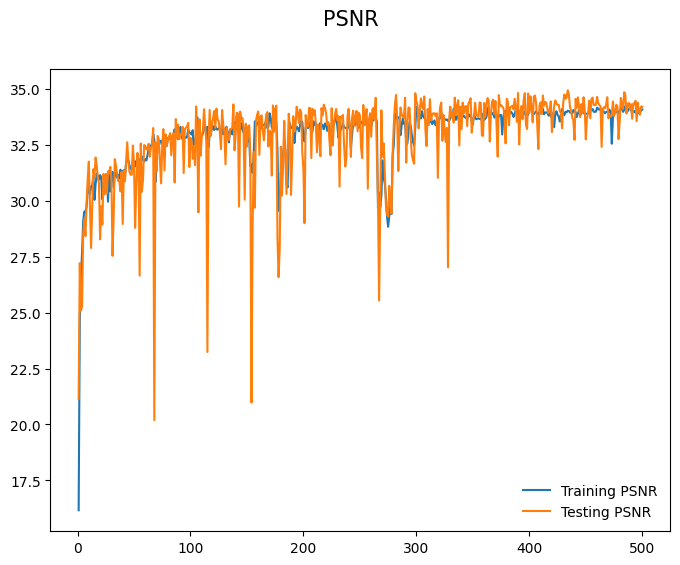

In [18]:
import matplotlib.pyplot as plt
x = [i for i in range(1,501)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("PSNR", fontsize = 15)
ax.plot(x, train_psnr, label="Training PSNR")
ax.plot(x, test_psnr, label="Testing PSNR")
plt.legend(loc="lower right", frameon=False)
plt.show()

In [19]:
from torchvision import transforms
from PIL import Image

# Create the preprocessing transformation here
transform = transforms.ToTensor()

# load your image(s)
img = Image.open('/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Test/pair_105_6/noise.jpg')

# Transform
input_ = transform(img)

print(input_)
input_ = input_

# unsqueeze batch dimension, in case you are dealing with a single image
input_ = input_.unsqueeze(0)

# Set model to eval
gen.eval()

# Get prediction
output = gen(input_)

tensor([[[0.0275, 0.0275, 0.0471,  ..., 0.0157, 0.0510, 0.0431],
         [0.0196, 0.0157, 0.0431,  ..., 0.0196, 0.0392, 0.0314],
         [0.0157, 0.0118, 0.0431,  ..., 0.0157, 0.0471, 0.0784],
         ...,
         [1.0000, 1.0000, 0.6431,  ..., 0.2627, 0.3451, 0.4549],
         [1.0000, 0.9961, 0.5843,  ..., 0.1961, 0.2353, 0.3725],
         [0.9725, 0.9686, 0.5255,  ..., 0.1725, 0.2824, 0.2902]],

        [[0.0196, 0.0118, 0.0078,  ..., 0.0627, 0.0588, 0.0314],
         [0.0196, 0.0157, 0.0196,  ..., 0.0667, 0.0471, 0.0196],
         [0.0392, 0.0353, 0.0431,  ..., 0.0627, 0.0510, 0.0588],
         ...,
         [0.9529, 0.9686, 0.6118,  ..., 0.6157, 0.6431, 0.7373],
         [0.9843, 0.9765, 0.6000,  ..., 0.5333, 0.5255, 0.6392],
         [0.9647, 0.9765, 0.5686,  ..., 0.5020, 0.5647, 0.5490]],

        [[0.0235, 0.0157, 0.0392,  ..., 0.0078, 0.0157, 0.0000],
         [0.0196, 0.0157, 0.0353,  ..., 0.0118, 0.0039, 0.0000],
         [0.0235, 0.0196, 0.0510,  ..., 0.0157, 0.0196, 0.

In [20]:
from torchvision.utils import save_image

# Assuming 'tensor' is your tensor
img1 = input_  # Get the first image tensor
save_image(img1, 'img1.png')  # Save the tensor as an image
img2 = output
save_image(img2,'img2.png')